## Cat or Dog with Transfer Learning

### Import libaries

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import pandas as pd

from keras_preprocessing.image import ImageDataGenerator

import os
import random
import shutil
import pathlib

In [2]:
base_dir = '../CatsVsDogs/input_for_model' # from my previous project

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

train_dogs = os.path.join(train_dir, 'dogs')
train_cats = os.path.join(train_dir, 'cats')
val_dogs = os.path.join(val_dir, 'dogs')
val_cats = os.path.join(val_dir, 'cats')

In [3]:
print(
    f"Number of dog images in train set - {len(os.listdir(train_dogs))}\nNumber of cat image in train set - {len(os.listdir(train_cats))}\n\nNumber of dog images in validation set - {len(os.listdir(val_dogs))}\nNumber of dog images in validation set - {len(os.listdir(val_cats))}"
)

Number of dog images in train set - 9375
Number of cat image in train set - 9375

Number of dog images in validation set - 3125
Number of dog images in validation set - 3125


In [23]:
img_shape = 224
batch_size = 8

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
resnet_url = "https://tfhub.dev/tensorflow/resnet_50/classification/1"
efficient_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/classification/2"

Here is i create 3 url from TensorFlow Hub. <br><b>TensorFlow Hub</b> is a repository of trained machine learning models.

### Image generator

In [5]:
train_image_generator = ImageDataGenerator(
        rescale=1. / 255
)
val_image_generator = ImageDataGenerator(rescale=1/255)

In [6]:
train_data_generator = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    class_mode='binary'
)

val_data_generator = val_image_generator.flow_from_directory(
    directory=val_dir,
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [7]:
def plot_Image(images):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

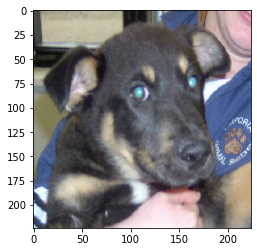

In [32]:
plt.imshow(train_data_generator.next()[0][0])
plt.show()

### Model

In [9]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

#### MobileNet

MobileNet-v2 is a convolutional neural network.<br>The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

<center>The architecture of MobileNet</center>

<img src='https://www.researchgate.net/publication/331675538/figure/fig2/AS:735605247967235@1552393366382/layers-of-MobileNet-architecture-4.ppm'>

In [34]:
mobile_net = hub.KerasLayer(mobile_net_url, input_shape=(img_shape, img_shape, 3))

mobile_net.trainable = False

In [93]:
model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [97]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [100]:
history = model.fit(train_data_generator,
                    validation_data=val_data_generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_steps=100)

Epoch 1/50
100/100 [==============================] - 69s 642ms/step - loss: 0.3257 - accuracy: 0.8717 - val_loss: 0.1111 - val_accuracy: 0.9538
Epoch 2/50
100/100 [==============================] - 57s 572ms/step - loss: 0.0994 - accuracy: 0.9677 - val_loss: 0.0496 - val_accuracy: 0.9800
Epoch 3/50
100/100 [==============================] - 55s 550ms/step - loss: 0.0642 - accuracy: 0.9782 - val_loss: 0.0749 - val_accuracy: 0.9675
Epoch 4/50
100/100 [==============================] - 48s 476ms/step - loss: 0.0846 - accuracy: 0.9756 - val_loss: 0.0483 - val_accuracy: 0.9787
Epoch 5/50
100/100 [==============================] - 48s 479ms/step - loss: 0.0642 - accuracy: 0.9722 - val_loss: 0.0586 - val_accuracy: 0.9750
Epoch 6/50
100/100 [==============================] - 49s 477ms/step - loss: 0.0563 - accuracy: 0.9779 - val_loss: 0.0221 - val_accuracy: 0.9900
Epoch 7/50
100/100 [==============================] - 47s 465ms/step - loss: 0.0471 - accuracy: 0.9806 - val_loss: 0.0245 - val_ac

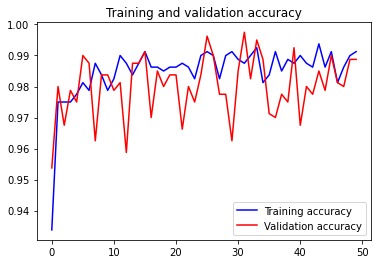

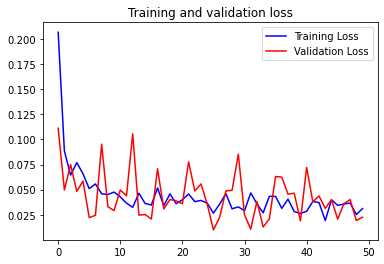

In [102]:
plot_result(history)

I already get 87% accuracy and loss 30% in the first epoch same as my base model in previous lab.

#### Resnet

<center>The architecture of ResNet</center>

<img src='https://miro.medium.com/max/625/1*2ns4ota94je5gSVjrpFq3A.png'>

In [10]:
res_net = hub.KerasLayer(resnet_url, input_shape=(img_shape, img_shape, 3))

res_net.trainable = False

In [11]:
model = tf.keras.models.Sequential([
    res_net,
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              25612201  
_________________________________________________________________
dense (Dense)                (None, 1)                 1002      
Total params: 25,613,203
Trainable params: 1,002
Non-trainable params: 25,612,201
_________________________________________________________________


In [14]:
history = model.fit(train_data_generator,
                    validation_data=val_data_generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_steps=100)

Epoch 1/50
100/100 [==============================] - 216s 2s/step - loss: 0.6955 - accuracy: 0.4461 - val_loss: 0.6752 - val_accuracy: 0.9600
Epoch 2/50
100/100 [==============================] - 194s 2s/step - loss: 0.6752 - accuracy: 0.8527 - val_loss: 0.6523 - val_accuracy: 0.9588
Epoch 3/50
100/100 [==============================] - 190s 2s/step - loss: 0.6534 - accuracy: 0.9660 - val_loss: 0.6300 - val_accuracy: 0.9525
Epoch 4/50
100/100 [==============================] - 191s 2s/step - loss: 0.6344 - accuracy: 0.9635 - val_loss: 0.6084 - val_accuracy: 0.9525
Epoch 5/50
100/100 [==============================] - 187s 2s/step - loss: 0.6143 - accuracy: 0.9789 - val_loss: 0.5871 - val_accuracy: 0.9500
Epoch 6/50
100/100 [==============================] - 188s 2s/step - loss: 0.5987 - accuracy: 0.9745 - val_loss: 0.5648 - val_accuracy: 0.9575
Epoch 7/50
100/100 [==============================] - 181s 2s/step - loss: 0.5810 - accuracy: 0.9733 - val_loss: 0.5500 - val_accuracy: 0.9500

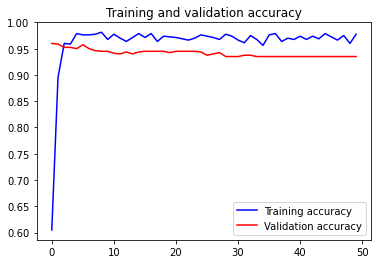

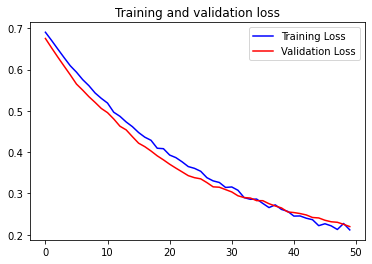

In [15]:
plot_result(history)

As we can see ResNet has a great accuracy but also relatively to MobileNet has more chance to make mistake.

#### Efficientnet

<center>The architecture of Efficientnet</center>

<img src='https://learnopencv.com/wp-content/uploads/2019/06/EfficientNet-B0-architecture-1024x511.png'>

In [24]:
efficient_net = hub.KerasLayer(efficient_url, input_shape=(img_shape, img_shape, 3))

efficient_net.trainable = False

In [25]:
model = tf.keras.models.Sequential([
    efficient_net,
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1000)              4694024   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 4,695,025
Trainable params: 1,001
Non-trainable params: 4,694,024
_________________________________________________________________


In [28]:
history = model.fit(train_data_generator,
                    validation_data=val_data_generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_steps=100)

Epoch 1/50
100/100 [==============================] - 65s 626ms/step - loss: 0.3527 - accuracy: 0.8342 - val_loss: 0.0912 - val_accuracy: 0.9675
Epoch 2/50
100/100 [==============================] - 61s 611ms/step - loss: 0.0594 - accuracy: 0.9820 - val_loss: 0.0443 - val_accuracy: 0.9800
Epoch 3/50
100/100 [==============================] - 61s 610ms/step - loss: 0.0758 - accuracy: 0.9728 - val_loss: 0.0532 - val_accuracy: 0.9762
Epoch 4/50
100/100 [==============================] - 61s 610ms/step - loss: 0.0651 - accuracy: 0.9825 - val_loss: 0.0262 - val_accuracy: 0.9900
Epoch 5/50
100/100 [==============================] - 63s 621ms/step - loss: 0.0396 - accuracy: 0.9866 - val_loss: 0.0507 - val_accuracy: 0.9837
Epoch 6/50
100/100 [==============================] - 61s 608ms/step - loss: 0.0494 - accuracy: 0.9840 - val_loss: 0.0144 - val_accuracy: 0.9925
Epoch 7/50
100/100 [==============================] - 79s 791ms/step - loss: 0.0723 - accuracy: 0.9786 - val_loss: 0.0274 - val_ac

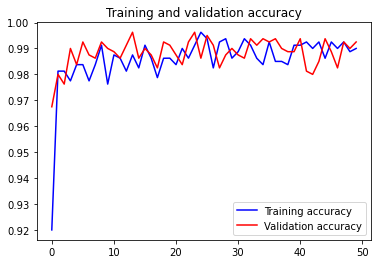

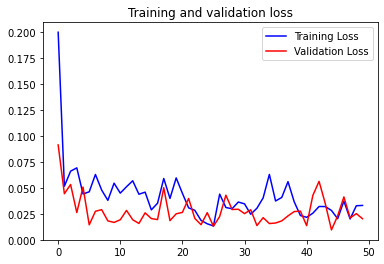

In [29]:
plot_result(history)